# Description

Perform asset optimization 


Methods : 
* Equally weighted
* 
* 
* 


**NE PAS OUBLIER**
* FAIRE LA RACINE CARREE SUR LA VOLATILITE POUR CALCULER LE RISQUE
* Implémentation rebalancement
* implémentation tracking error (voir https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/tracking-error/)
* astuce de modelisation gurobipy
    * https://support.gurobi.com/hc/en-us/community/posts/360074491212-Divisor-must-be-a-constant
    * http://yetanothermathprogrammingconsultant.blogspot.com/2016/08/portfolio-optimization-maximize-sharpe.html

# Setup

In [1]:
%matplotlib notebook
%load_ext autoreload

## Imports

In [2]:
# os related
from pathlib import Path
import os 

# data related
import pandas as pd
import missingno as msno
import datetime as dt
import numpy as np

# optimization related
from gurobipy import (Model, GRB, quicksum, multidict, tuplelist)

# visual related
import matplotlib.pyplot as plt
import seaborn as sns

# time related


In [3]:

from fonctions import *

## Paths

In [104]:
# MUST BE IN CODE FOLDER TO WORK !
PROJECT_PATH = Path(os.getcwd()).parent

RAW_DATA = PROJECT_PATH / "RAW_DATA" 
PROC_DATA = PROJECT_PATH / "PROC_DATA"

# RAW FILES
CSV_FILE = RAW_DATA / "Individual_stock_data_csv.csv"
XLSX_FILE = RAW_DATA / "Individual_stock_data.xlsx"

# PROC FILES
PROC_STOCK = PROC_DATA / "proc_stock.csv"
PROC_CARBON = PROC_DATA / "proc_carbon.csv"

STOCK_2000 = PROC_DATA / "stock_2000.csv"


STOCK_WORK = PROC_DATA / "stock_work.csv"
STOCK2USE = PROC_DATA / "stock2use.csv"
DIC2USE = PROC_DATA / "dic2use.json"


OUT_RENDEMENT = PROC_DATA / "rendement_v1"

OUT_DF_CSV = PROC_DATA / "optimize_assets.csv"

## Utils

# Notebook

## Loading data

In [5]:
df = read_file(STOCK2USE)

In [6]:
carbon_df = read_file(PROC_CARBON, index="company")

## EW

In [7]:
mean, std = equally_weighted(df) # correct std function in fonctions.py 

ValueError: too many values to unpack (expected 2)

In [ ]:
weeks = 12
nb_period = len(df)//12

In [8]:
# df_period = 
# compute_weights(df_period, method)
# apply weights
# compute(return and risk)
# compute

<IPython.core.display.Javascript object>


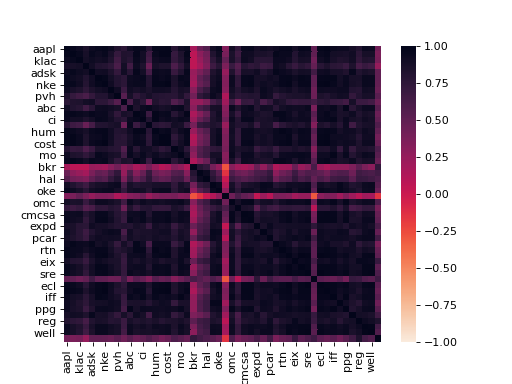

<AxesSubplot:>

In [9]:

sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap="rocket_r")


## GMV

In [10]:
cov = df.cov().to_numpy()

In [11]:
def gmv(cov, nb_weights=50):
    """Function that computes weights for global minimum volatility
    Parameters:
    cov(matrix):covariance of data
    nb_weights(int):number of weights to optimize
    Returns:
    weights(list)"""
    
    model = Model()
    model.modelSense = GRB.MINIMIZE

    # Définir poids
    w = model.addVars(len(df.columns), vtype=GRB.CONTINUOUS, ub=1)

    arr = np.array(w.select("*"))
    vecw_col = np.reshape(arr, (len(arr), 1)) # vecteur colonne des poids

    # Contraintes
    model.addConstr(w.sum() == 1)
    

    obj = np.dot(vecw_col.T,np.dot(cov, vecw_col))
    model.setObjective(obj[0][0])

    model.setParam('OutputFlag', 0) # Mute output
    model.update()
    model.optimize()
    
    opt_w =  [w[i].x for i in range(len(w))]
    
    return opt_w

    
    

In [ ]:
# max_weight = max(opt_w)
# opt_w.index(max_weight)

## Max Decor

In [12]:
cor = df.corr().to_numpy()

<IPython.core.display.Javascript object>


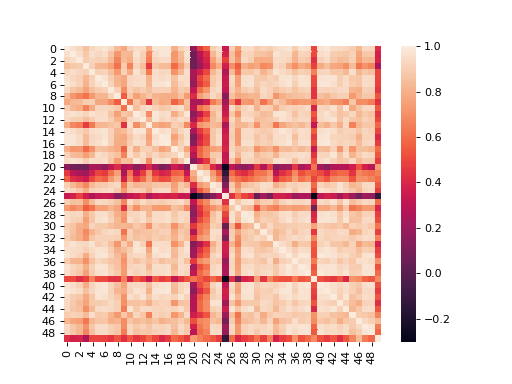

<AxesSubplot:>

In [13]:
plt.figure()
sns.heatmap(cor)

In [29]:
def max_decor(corr, nb_weights=50):
    model = Model()

    model.modelSense = GRB.MINIMIZE

    # Définir poids
    w = model.addVars(len(df.columns), vtype=GRB.CONTINUOUS, ub=1)
    arr = np.array(w.select("*"))
    vecw_col = np.reshape(arr, (len(arr), 1)) # vecteur colonne des poids
    # Contraintes
    model.addConstr(w.sum() == 1)
    obj = np.dot(vecw_col.T,np.dot(corr, vecw_col))
    model.setObjective(obj[0][0])
    
    model.setParam('OutputFlag', 0) # Mute output
    model.update()
    model.optimize()
    
    opt_w =  [w[i].x for i in range(len(w))]
    return opt_w
    
    
    
    

In [15]:
# opt_w = [w[i].x for i in range(len(w))]
# max_weight = max(opt_w)
# max_idx = opt_w.index(max_weight)
# df.columns[max_idx]

<IPython.core.display.Javascript object>


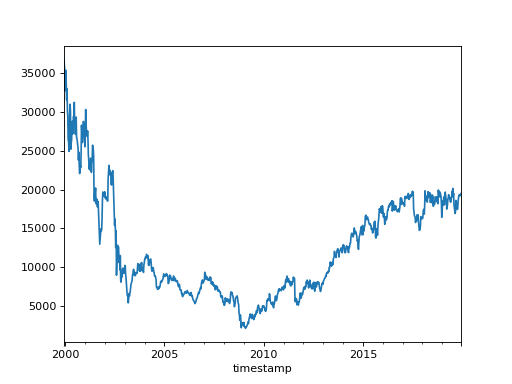

<AxesSubplot:xlabel='timestamp'>

In [30]:
plt.figure()
df["ipg"].plot()

In [31]:
carbon_df.loc["ipg"]

name                     INTERPUBLIC GROUP
sector                                  50
sector_name         Communication Services
scope1                              2.2577
scope2                             20.9515
emissions                          23.2092
market_value                        8941.1
revenues                            9714.4
carbon_footprint                  2.595788
intensity                         2.389154
Name: ipg, dtype: object

In [32]:
df.corr()[["ipg"]].describe().quantile()

ipg    0.300181
Name: 0.5, dtype: float64

In [33]:
for weight in sorted(opt_w, reverse=True):
    idx = opt_w.index(weight)
    print(df.columns[idx])

NameError: name 'opt_w' is not defined

In [20]:
df.corr()[["omc"]].describe()

,omc
count,50.000000
mean,0.852796
std,0.147508
min,0.321145
25%,0.854793
50%,0.902291
75%,0.935217
max,1.000000


In [21]:
carbon_df.loc["omc"]

name                         OMNICOM GROUP
sector                                  50
sector_name         Communication Services
scope1                              23.961
scope2                              77.445
emissions                          101.406
market_value                       17904.1
revenues                           15290.2
carbon_footprint                  5.663842
intensity                         6.632091
Name: omc, dtype: object

## Max div

In [22]:
def max_div(cov, nb_weights=50):
    
    
    model = Model()
    model.modelSense = GRB.MINIMIZE
    y = model.addVars(len(df.columns), vtype=GRB.CONTINUOUS)
    arr = np.array(y.select("*"))
    vecy_col = np.reshape(arr, (len(arr), 1)) 

    strd = np.sqrt(np.diag(cov))
    
    yp = np.dot(vecy_col.T,np.reshape(strd,(len(strd),1)))

    port_variance = np.dot(vecy_col.T,np.dot(cov, vecy_col))[0][0]

    model.addConstr(yp[0][0] == 1)
    obj = port_variance

    model.setObjective(obj)
    model.setParam('OutputFlag', 0) # Mute output
    model.update()
    model.optimize()
    
    opt_w = [y[i].x /y.sum().getValue() for i in range(len(y))]
    
    return opt_w

In [23]:
xopt = [y[i].x /y.sum().getValue() for i in range(len(y))]

NameError: name 'y' is not defined

## MSR

In [24]:
def msr(mu, cov, nb_weights=50):
    
    model = Model()
    model.modelSense = GRB.MINIMIZE

    y = model.addVars(nb_weights, vtype=GRB.CONTINUOUS)
    arr = np.array(y.select("*"))
    vecy_col = np.reshape(arr, (len(arr), 1))

    yp = np.dot(vecy_col.T,np.reshape(mu,(len(mu),1)))
    port_variance = np.dot(vecy_col.T,np.dot(cov, vecy_col))[0][0]

    model.addConstr(yp[0][0] == 1)
    obj = port_variance

    model.setObjective(obj)

    model.setParam('OutputFlag', 0) # Mute output
    model.update()
    model.optimize()

    opt_w = [y[i].x for i in range(len(y))]
    
    return opt_w
    
    

**deprecated**

In [25]:
# Astuce de modélisation Sharp Ratio
# y est utilisée pour la transformation du problème
# xVar et yVar pour modéliser la racine carrée

model = Model()
model.modelSense = GRB.MINIMIZE


# Définir poids
y = model.addVars(len(df.columns), vtype=GRB.CONTINUOUS, ub=1)
arr = np.array(y.select("*"))
vecy_col = np.reshape(arr, (len(arr), 1)) 

mu = df.pct_change().mean().tolist()
yp = np.dot(vecy_col.T,np.reshape(mu,(len(mu),1)))

xVar = model.addVar(vtype=GRB.CONTINUOUS)
yVar = model.addVar(vtype=GRB.CONTINUOUS)

port_variance = np.dot(vecy_col.T,np.dot(cov, vecy_col))[0][0]
model.addConstr(xVar == port_variance)
model.addGenConstrPow(xVar, yVar, 0.5)


model.addConstr(yp[0][0] == 1)
    

model.setParam("Nonconvex", 2)

    
obj = 1 / yVar


model.setObjective(obj)


model.update()
model.optimize()


Using license file c:\gurobi912\gurobi.lic
Set parameter TokenServer to value dev.cma.mines-paristech.fr
Changed value of parameter Nonconvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1


TypeError: unsupported operand type(s) for /: 'int' and 'Var'

In [26]:
[y[i].x for i in range(len(y))]
xopt = [y[i].x /y.sum().getValue() for i in range(len(y))]

AttributeError: Index out of range for attribute 'X'

## Rebalancement

In [ ]:
# de la semaine 0 à la semaine 103
nb_period = (len(df) - 104) // 12

# output dataframe
cols= ["ew", "gmv", "maxdecor", "maxdiv", "msr"]
out_df = pd.DataFrame(index=range((len(df) - 104)), columns=cols)

for i in range((nb_period)):
    print(i)
    
    # retrieve data
    temp_df = df.iloc[i*12:104+i*12] # 2 dernieres annees glissantes sur 3 mois
    # print(temp_df.index[0],"->",temp_df.index[-1], len(temp_df))
    mu = temp_df.pct_change().mean() # Vérifier s'il faut enlever les Nans
    cov = temp_df.cov()
    std = temp_df.std()
    corr = temp_df.corr()
    
    # Train
    w_gmv = gmv(cov)
    w_mdecor = max_decor(corr)
    w_mdiv = max_div(cov)
    w_msr = msr(mu.values, cov)
    
    # Test
    test_period = df.iloc[-1+104+i*12:104+(i+1)*12]  # test data sur les 3 mois suivants   
    test_mu = test_period.pct_change()[1:]
     
    out_df["gmv"].iloc[i*12:(i+1)*12] = (test_mu * w_gmv).sum(axis=1) * 100
    out_df["maxdecor"].iloc[i*12:(i+1)*12] = (test_mu * w_mdecor).sum(axis=1) * 100
    out_df["maxdiv"].iloc[i*12:(i+1)*12] = (test_mu * w_mdiv).sum(axis=1) * 100
    out_df["msr"].iloc[i*12:(i+1)*12] = (test_mu * w_mdiv).sum(axis=1) * 100
    out_df["ew"].iloc[i*12:(i+1)*12] = (test_mu.sum(axis=1) / len(test_period.columns)) * 100

    

In [99]:
len(out_df)

940

In [101]:
out_df.dropna(inplace=True)

In [105]:
out_df.to_csv(OUT_DF_CSV)

## Calcul des metrics


In [ ]:
# Rendement annualisé

# Ratio de sharp

# Tracking error

# Excess return 

# Rendement du S&P 500

# Calcul de l'ENC


Sur les 1 an
* Rendement portefeuille (annualisé) 
* Risque du portefeuille (annualisé)
* tracking error 
* mu / sigma
* mup - mub (ecés par rapport au benchmark)
* (mup - mub) / tracking error
* EnC / 50 (50%)